In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [2]:
thyroid_path = "thyroid_cancer_risk_data.csv"

thy_data = pd.read_csv(thyroid_path)

thy_data.head()

,Patient_ID,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,1,66,Male,Russia,Caucasian,No,Yes,No,No,No,No,9.37,1.67,6.16,1.08,Low,Benign
1,2,29,Male,Germany,Hispanic,No,Yes,No,No,No,No,1.83,1.73,10.54,4.05,Low,Benign
2,3,86,Male,Nigeria,Caucasian,No,No,No,No,No,No,6.26,2.59,10.57,4.61,Low,Benign
3,4,75,Female,India,Asian,No,No,No,No,No,No,4.10,2.62,11.04,2.46,Medium,Benign
4,5,35,Female,Germany,African,Yes,Yes,No,No,No,No,9.10,2.11,10.71,2.11,High,Benign


In [3]:
missing_values = thy_data.isnull().sum()
print('Missing values in each column:')
print(missing_values)

Missing values in each column:
Patient_ID             0
Age                    0
Gender                 0
Country                0
Ethnicity              0
Family_History         0
Radiation_Exposure     0
Iodine_Deficiency      0
Smoking                0
Obesity                0
Diabetes               0
TSH_Level              0
T3_Level               0
T4_Level               0
Nodule_Size            0
Thyroid_Cancer_Risk    0
Diagnosis              0
dtype: int64


In [4]:
print('Duplicate rows count:', thy_data.duplicated().sum())

Duplicate rows count: 0


In [5]:
thy_data = thy_data.dropna()

In [6]:
thy_data.reset_index(drop=True, inplace=True)
print('Cleaned DataFrame shape:', thy_data.shape)

Cleaned DataFrame shape: (212691, 17)


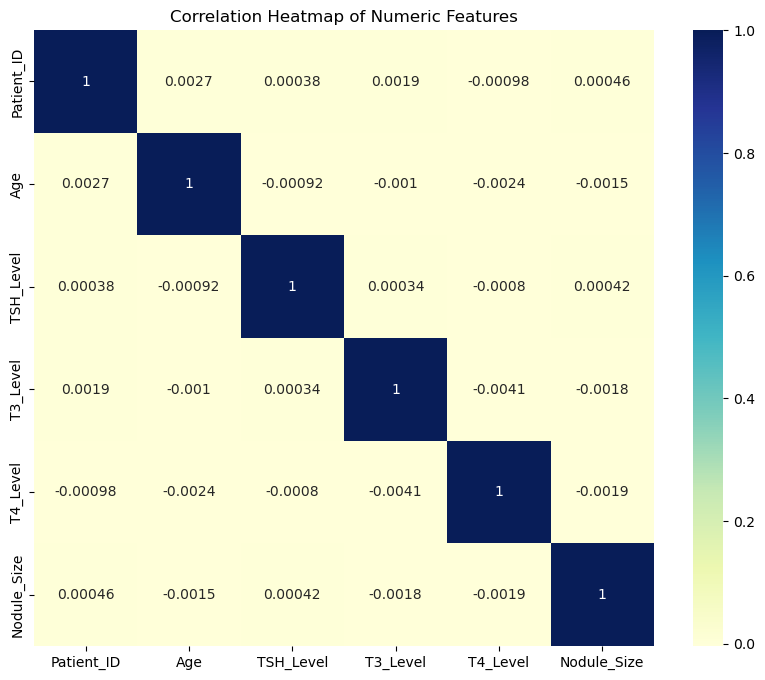

In [7]:
numeric_df = thy_data.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sb.heatmap(corr, annot=True, cmap='YlGnBu')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()
else:
    print("Not enough numeric columns for a correlation heatmap")

# Heatmap shows that there is little to no correlation

In [8]:
Dia_dis = thy_data["Diagnosis"].value_counts(normalize=True)
Dia_dis

Diagnosis
Benign       0.767292
Malignant    0.232708
Name: proportion, dtype: float64

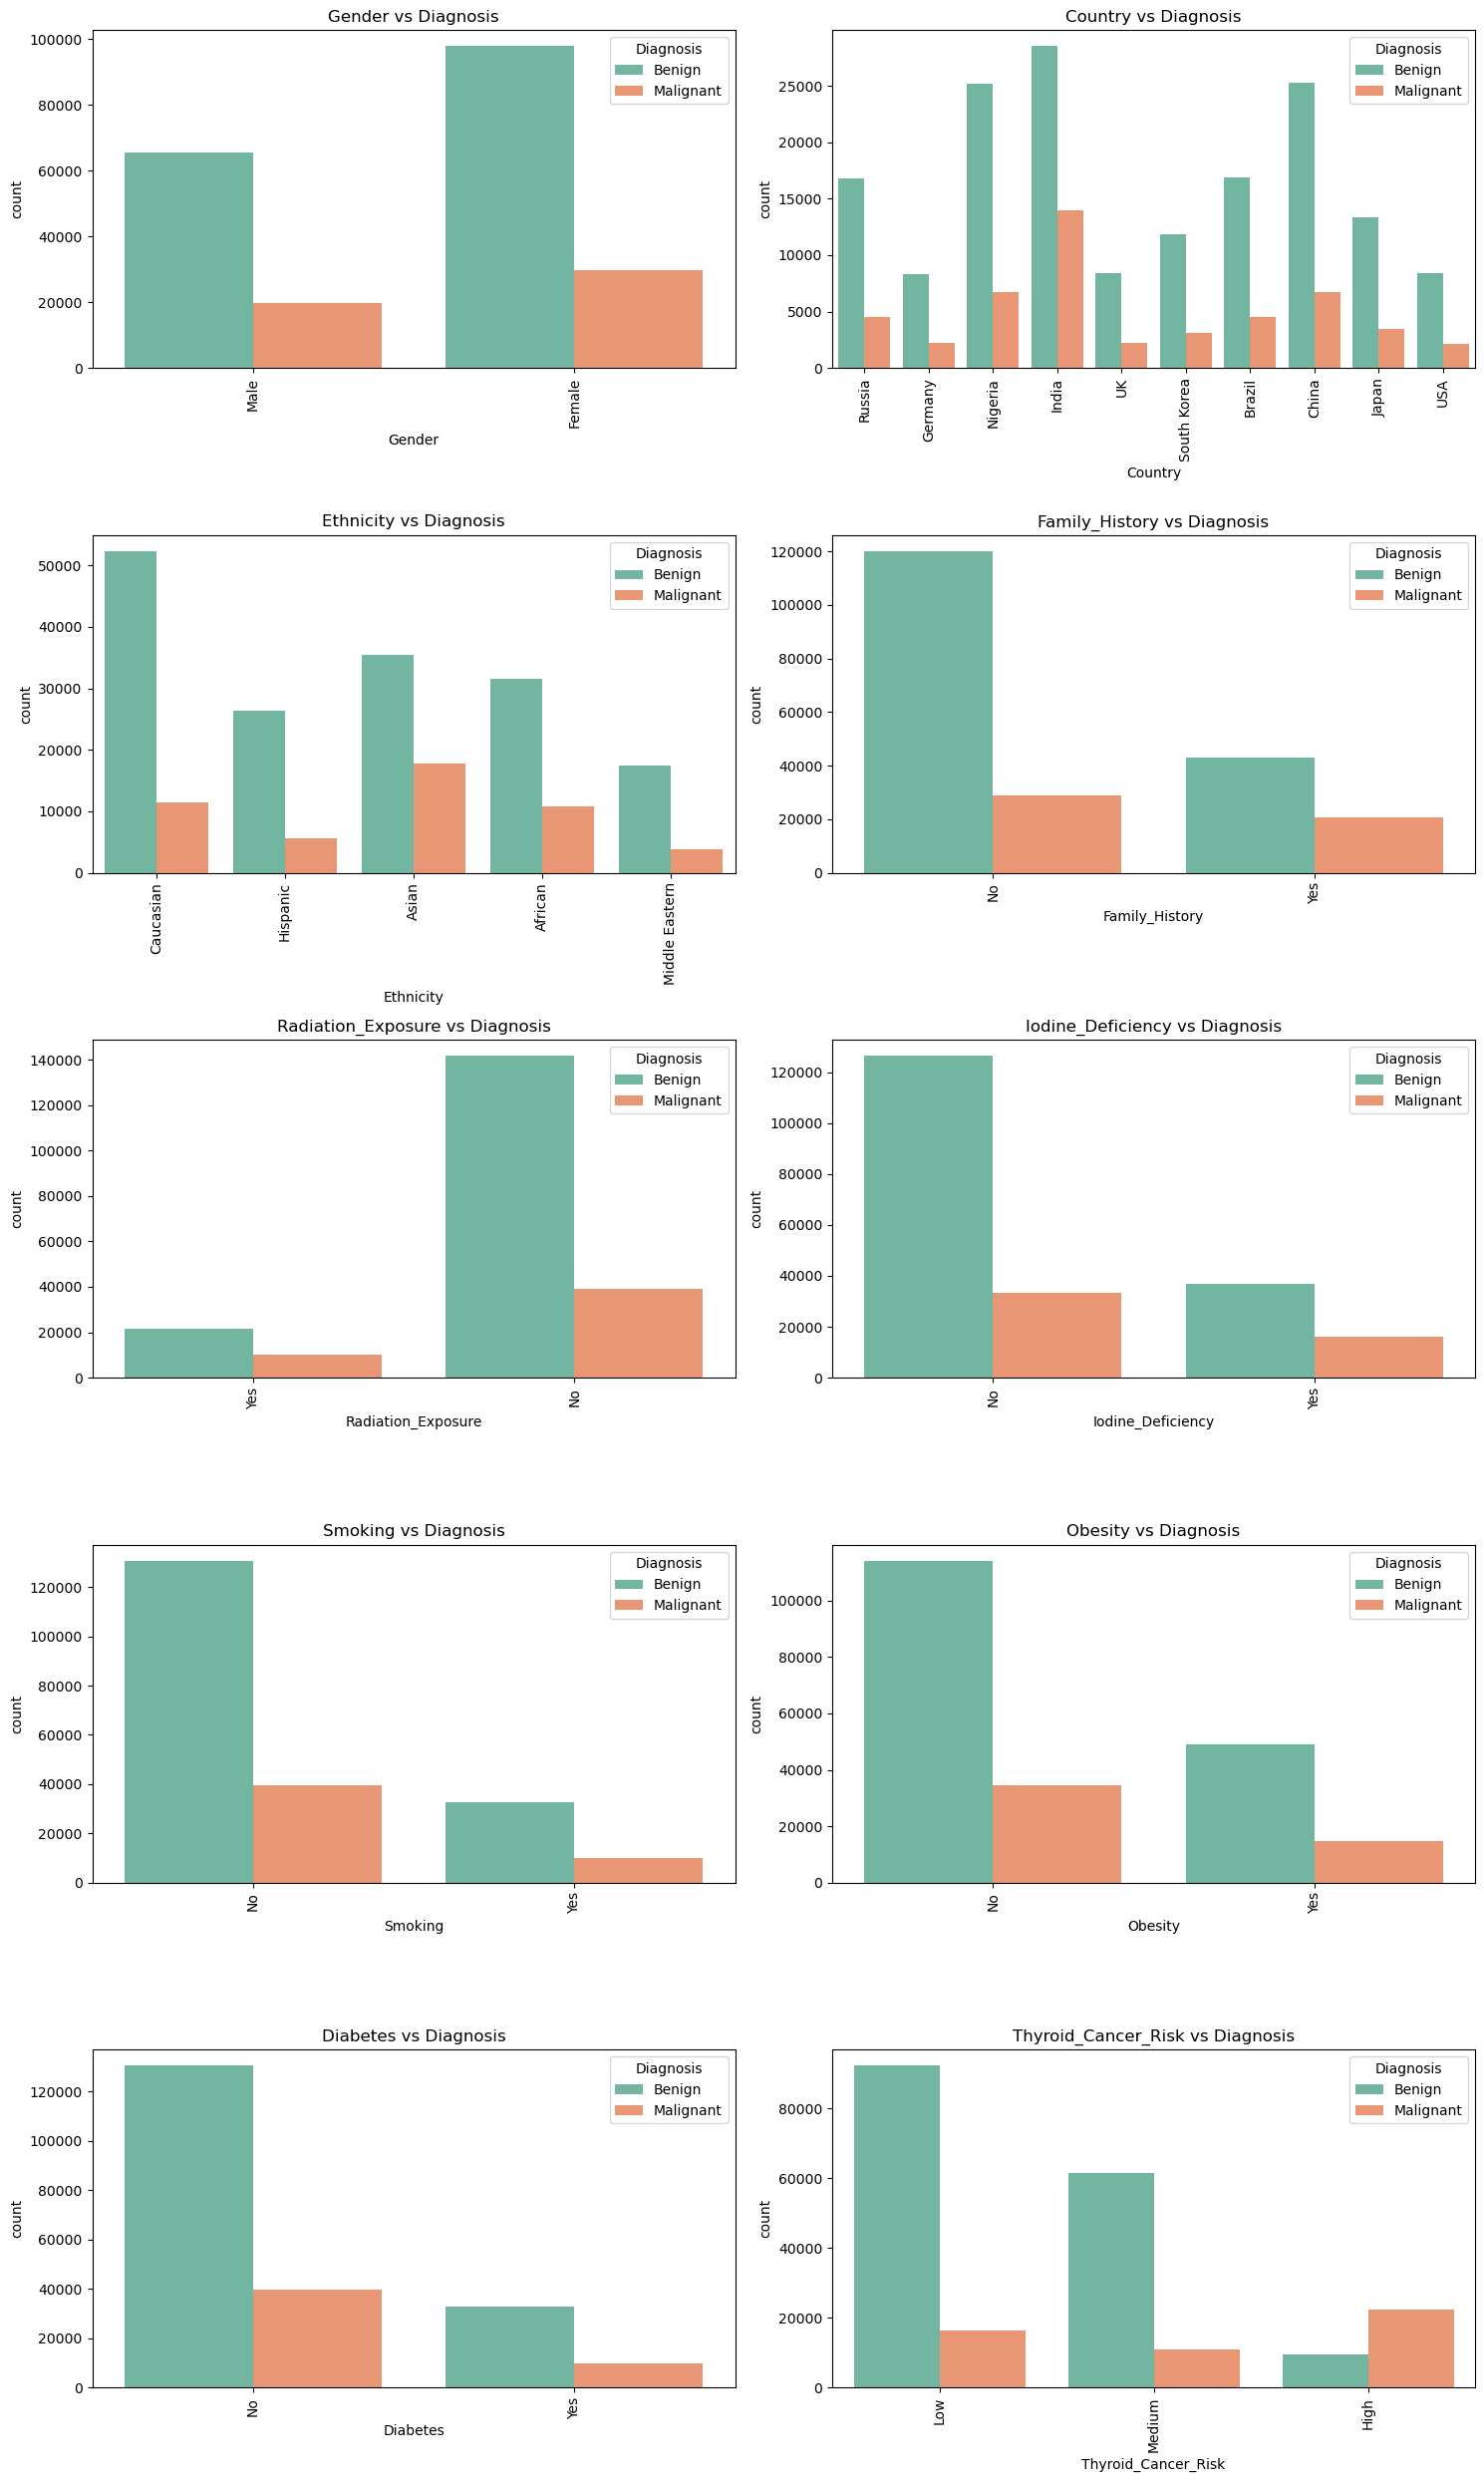

In [9]:
df_cat = thy_data.select_dtypes(include='object').drop(columns=['Diagnosis'], errors='ignore')


col_count = len(df_cat.columns)
nrows = (col_count + 1) // 2 
ncols = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten() if col_count > 1 else [axes]


for i, column in enumerate(df_cat.columns):
    sb.countplot(x=thy_data[column], hue=thy_data['Diagnosis'], ax=axes[i], palette='Set2')
    axes[i].set_title(f'{column} vs Diagnosis')
    axes[i].tick_params(axis='x', rotation=90)


if col_count % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [10]:
df_cat = thy_data.select_dtypes(include='object')

label_encoders = {}

for column in df_cat.columns:
    le = LabelEncoder()
    thy_data[column] = le.fit_transform(thy_data[column]) 
    label_encoders[column] = le  

print(thy_data.head())

   Patient_ID  Age  Gender  Country  Ethnicity  Family_History  \
0           1   66       1        6          2               0   
1           2   29       1        2          3               0   
2           3   86       1        5          2               0   
3           4   75       0        3          1               0   
4           5   35       0        2          0               1   

   Radiation_Exposure  Iodine_Deficiency  Smoking  Obesity  Diabetes  \
0                   1                  0        0        0         0   
1                   1                  0        0        0         0   
2                   0                  0        0        0         0   
3                   0                  0        0        0         0   
4                   1                  0        0        0         0   

   TSH_Level  T3_Level  T4_Level  Nodule_Size  Thyroid_Cancer_Risk  Diagnosis  
0       9.37      1.67      6.16         1.08                    1          0  
1       1.

In [11]:
X = thy_data.drop(columns=["Patient_ID", "Diagnosis"])
Y = thy_data["Diagnosis"]

X_scaled = StandardScaler().fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

## A RandomForestClassifier model is created with a fixed random_state of 42 (for reproducibility).
## The random forest classifier is an ensemble model that builds multiple decision trees and combines their results.

## The param_dist dictionary defines the hyperparameter grid that will be searched to find the best model configuration.
## These are common hyperparameters for a Random Forest:
<ul>
<li>n_estimators: The number of trees in the forest (50, 100, 200, or 300).</li>
<li>max_depth: The maximum depth of each tree (None means unlimited depth, or it can be limited to 10, 20, or 30).</li>
<li>min_samples_split: The minimum number of samples required to split an internal node (can be 2, 5, or 10).</li>
<li>min_samples_leaf: The minimum number of samples required to be at a leaf node (can be 1, 2, or 4).</li>
<li>max_features: The number of features to consider for the best split ('sqrt' is square root of the number of features, 'log2' is the log base 2 of the number of features, or it can be None for no limitation).</li>
<li>bootstrap: Whether bootstrap samples are used when building trees. It can be True (samples with replacement) or False (without replacement).</li>
</ul>

In [13]:
rf_model = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
}


## RandomizedSearchCV is used for hyperparameter optimization. Unlike GridSearchCV, which tests all possible combinations of hyperparameters, RandomizedSearchCV samples a fixed number of combinations (in this case, 5 combinations).
#### The parameters of RandomizedSearchCV:
<ul>
<li>estimator: The model you want to tune, in this case, the RandomForestClassifier.</li>
<li>param_distributions: The hyperparameter grid (defined earlier) from which random samples are drawn.</li>
<li>n_iter=5: The number of random combinations of hyperparameters to try.</li>
<li>scoring='accuracy': The evaluation metric to optimize (here, it's accuracy).</li>
<li>cv=3: 3-fold cross-validation is used to evaluate the model's performance.</li>
<li>verbose=1: Prints progress messages during the fitting process.</li>
<li>random_state=42: Ensures reproducibility of the random sampling process.</li>
<li>n_jobs=-1: Uses all available CPU cores to parallelize the computation (speeds up the process).</li>
</ul>

In [15]:
%%time

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                   n_iter=5, scoring='accuracy', cv=3, verbose=1, 
                                   random_state=42, n_jobs=-1)


random_search.fit(X_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: total: 56.8 s
Wall time: 6min 53s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42, scoring='accuracy', verbose=1)

### random_search.best_params_ returns the best combination of hyperparameters found during the search. <br> random_search.best_score_ returns the highest cross-validation accuracy achieved using those best hyperparameters.

In [16]:
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)

Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
Best Cross-Validation Accuracy: 0.8279303260519862


## random_search.best_estimator_ retrieves the best model (Random Forest) with the optimal hyperparameters. <br> best_rf_model.predict(X_test) makes predictions using the best model on the test data (X_test).

## accuracy_score(y_test, y_pred) calculates the accuracy of the model on the test data (how many predictions were correct). <br>classification_report(y_test, y_pred) provides a detailed evaluation of the classification performance, including metrics such as precision, recall, and F1-score for each class.

In [17]:
best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred)) 
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.8250546557276852
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89     32615
           1       0.69      0.45      0.54      9924

    accuracy                           0.83     42539
   macro avg       0.77      0.69      0.72     42539
weighted avg       0.81      0.83      0.81     42539



# The accuracy of 0.83 is good, but this metric can be misleading, especially when there is an imbalance in the dataset (class 0 is much more frequent than class 1).

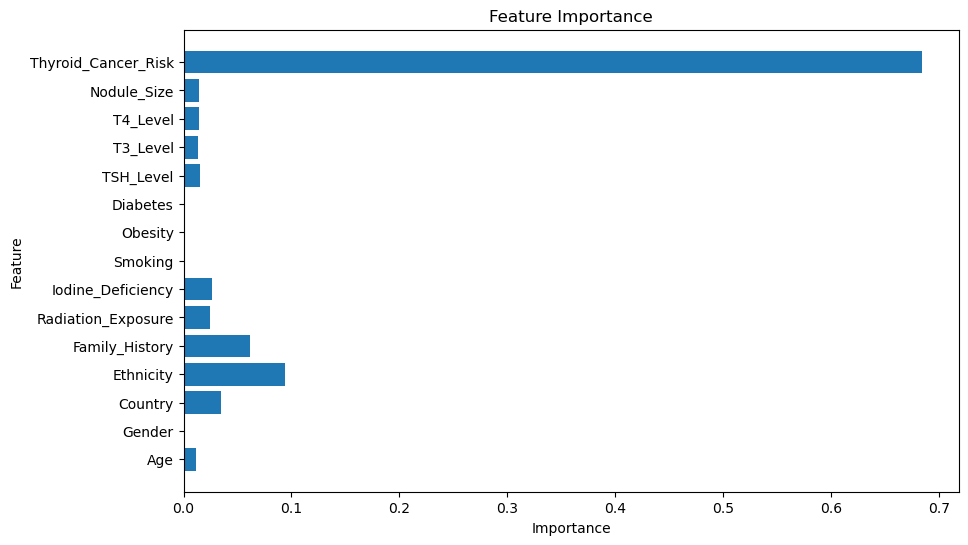

In [18]:
feature_importances = best_rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances) 
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

# Thyroid cancer risk is the highest cause followed by ethnicity in the factors of thyroid cancer according to these findings.

In [19]:
malignant_df = df_cat[df_cat['Diagnosis'] == 'Malignant']
ethnicity_count = malignant_df['Ethnicity'].value_counts().reset_index()
ethnicity_count.columns = ['Ethnicity', 'Count']
print(ethnicity_count)

        Ethnicity  Count
0           Asian  17820
1       Caucasian  11366
2         African  10804
3        Hispanic   5679
4  Middle Eastern   3826


<Axes: xlabel='Ethnicity', ylabel='Count'>

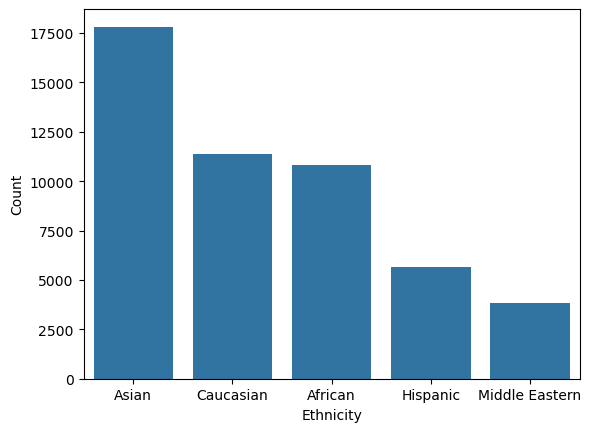

In [20]:
sb.barplot(x = "Ethnicity", y = "Count", data = ethnicity_count)